# Lane-Emden equation Solver by W4

* Differential equation which describes the stellar structure
* It is obtained from the Euler equation(fluid )

# Package Inclusion
* Sympy :: To define the set of nonlinear equations
* Numpy :: For iterative solver
* Scipy :: To use Linear solver
* Matplotlib :: For Basin figure

In [1]:
import sympy as sy;
import numpy as np;
from numpy import cos,sin,pi;
from scipy import linalg;
import matplotlib.pyplot as plt;

# Parameter Setup
For the W4 method, we define
* dim : dimension of system  (It determines the resolution)
* dtau : $\Delta\tau$ for evolution
* errmax : Criterion of error to stop iteration
* itermax : Maximum iteration.

In [2]:
dim=10;

In [3]:
dtau=0.5;
errmax = pow(10,-4);
itermax = pow(10,2);

In [4]:
### Variables
### x[1], x[2], x[3], ... , x[dim]
### 
x = []
for i in range(0,dim):
    vname = 'x[' + str(i) +']';
    x.append(sy.symbols(vname));

# Definition of Source in the Sympy style
* **F**(**x**) : System of nonlinear equations
* |**F**(**x**)| : Absolute components
* J : Jacobian matrix $\partial$ **F** / $\partial$ **x**

# $\frac{d^2\theta}{d\xi^2}+\frac{2}{\xi}\frac{d\theta}{d\xi}+r_{*}^2\theta^{n}=0$

In [5]:
### Source
### f[0], f[1], f[2], ... , f[dim-1]
n = 1;
f = [];

### Coordinate xi
dx = 1.0/dim;
xi = [];
for i in range(dim+1):
    xi.append( dx*i );

    
### Source for Eigenvalue x[0]
f.append( 6*(x[1] -1)/dx**2  +x[0] );

### Source for x[1] (theta(dx)) with boundary condition theta(0)=1
f.append( (x[2] -2*x[1] +1)/dx**2 +(x[2]-1)/xi[1]/dx +x[1]**n*x[0] );

for i in range(2,dim-1):
    f.append( (x[i+1] -2*x[i] +x[i-1])/dx**2 +(x[i+1]-x[i-1])/xi[i]/dx +x[i]**n*x[0] );

### Source for x[dim-1] (theta(1-dx)) with boundary condition theta(1)=0
f.append( (0 -2*x[dim-1] +x[dim-2])/dx**2 +(0-x[dim-2])/xi[dim-1]/dx +x[dim-1]**n*x[0] );

#f
tmp = f[0];
#norm = 0.0;
for i in range(1,dim):
    tmp = tmp +f[i]*x[i];
#    norm = norm +x[i]**n*x[i];

f[0] = tmp;

In [6]:
# input source
def calc_source(x,f):

### Summation of absolute values of all terms in each equation
###  to compare the error with the typical value of each equation
    fa = [];
    for j in range(dim):
        tmp = 0;
        for i in range(len(f[j].args)):
            tmp = tmp + abs(f[j].args[i]);
        fa.append(tmp);        

### Definition of variables, sources, absolute sources(x, F, |F|) as vector
    v = sy.Matrix([x]).transpose();
    F = sy.Matrix([f]).transpose();
    Fa = sy.Matrix([fa]).transpose();
    
### Analytic calculation of Jacobian(dim x dim Matrix)
    J = sy.Matrix();
    for i in range(dim):
        J = J.col_insert(i,F.diff(x[i]));    

### From Sympy to Numpy
    arg = v.transpose();
    vn = sy.lambdify(arg, v, "numpy")
    Fn = sy.lambdify(arg, F, "numpy")
    Fan = sy.lambdify(arg, Fa, "numpy")
    Jacn = sy.lambdify(arg, J, "numpy")        
        
    return vn,Fn,Fan,Jacn;

In [7]:
vn, Fn, Fan, Jacn = calc_source(x,f);

# Definition :: W4LH method

In [8]:
### Analysis by the W4 method with the LH decomposition
def w4analysis(v,F,Fa,J,ini,dt,itermax,errmax):
    
### Initialization for x and p as v0 and p0
    p0 = np.zeros(dim);
    v0 = v(*ini).transpose()[0];

    evot = [];
    evot = np.append(evot,0);
    evox = np.array([v0]).reshape(1,dim);
    evop = np.array([p0]).reshape(1,dim);
    evolam = [];
    J0=J(*v0);
    lam = linalg.eigvals(J0)
    lmin=abs(lam[0]);
    lmax=abs(lam[0]);
    for d in range(dim):
        if lmin > abs(lam[d]):
            lmin = abs(lam[d]);
        if lmax < abs(lam[d]):
            lmax = abs(lam[d]);

    evolam = np.append(evolam,lmax/lmin);

    
### Main Iteration Loop
    for i in range(itermax):
        J0=J(*v0);
        F0=F(*v0).transpose()[0].transpose();
        Fa0=Fa(*v0).transpose()[0].transpose();

### Criterion to stop the iteration
### Evaluation of Source F
        err = 0.0;
        for k in range(dim):
            err = max(err,abs(F0[k]/Fa0[k]));
            
        if err < errmax:
            break;

### Decomposition of Jacobian into L and H
        Q, R = linalg.qr(J0.transpose());
        srcp = -2*p0 -linalg.solve(R.transpose(),F0);
        srcx = Q.dot(p0);
#        srcx = Q.transpose().dot(p0);
        v0 = v0 +srcx*dt;
        p0 = p0 +srcp*dt;
        evot = np.append(evot,i);
        evox = np.append(evox,np.array([v0]),axis=0);
        evop = np.append(evop,np.array([p0]),axis=0);

        lam = linalg.eigvals(J0)
        lmin=abs(lam[0]);
        lmax=abs(lam[0]);
        for d in range(dim):
            if lmin > abs(lam[d]):
                lmin = abs(lam[d]);
            if lmax < abs(lam[d]):
                lmax = abs(lam[d]);

        evolam = np.append(evolam,lmax/lmin);

    return v0, i, err, evolam, evot, evox, evop

In [9]:
### Initial guess
vini = np.array([]);
vini = np.append(vini, 1.);
for i in range(1,dim):
    vini = np.append(vini, (1.0 -dx*i));

### Nonlinear Solver by the W4 method
vans, iter, err, lam, t, xr, pr = w4analysis(vn,Fn,Fan,Jacn,vini,dtau,itermax,errmax);

### Basic information
print("Dimension : ",dim);
print("Initial Condition number : ",lam[1]);
print("Iteration : ",iter,", error : ", err);
if iter < itermax-1:
    print("< Solved. >");
else:
    print("< Failed. >");

Dimension :  10
Initial Condition number :  20.20479855607713
Iteration :  18 , error :  9.286612538109219e-05
< Solved. >


In [10]:
sol = [];
sol = np.append(sol,1.0);
for i in range(1,dim):
    sol = np.append(sol,xr[iter][i]);
    
sol = np.append(sol,0.0);

#sol

r = [];
for i in range(dim+1):
    r = np.append(r,xi[i]*xr[iter][0]**0.5);


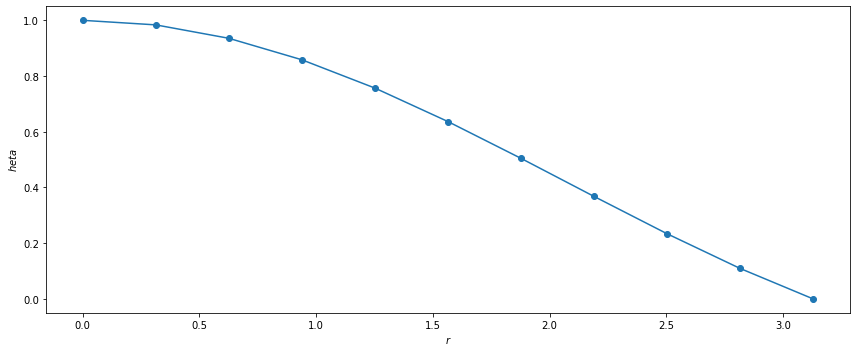

In [11]:
### Figures
fig = plt.figure(figsize=(12,5));
ax1 = fig.add_subplot(1,1,1);
ax1.plot(r,sol,marker='o');
ax1.set_xlabel("$r$");
ax1.set_ylabel("$\theta$");

fig.tight_layout();

In [12]:
### Saving solution during the W4 iteration for figures
solx0 = [];
solx1 = [];
solp0 = [];
solp1 = [];
for i in range(iter+1):
    solx0 = np.append(solx0,xr[i][0]);
    solx1 = np.append(solx1,xr[i][1]);
    solp0 = np.append(solp0,pr[i][0]);
    solp1 = np.append(solp1,pr[i][1]);

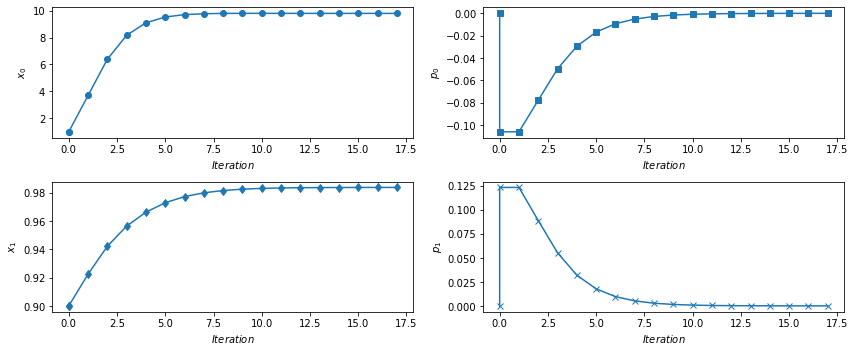

In [13]:
### Figures
fig = plt.figure(figsize=(12,5));
ax1 = fig.add_subplot(2,2,1);
ax1.plot(t,solx0,marker='o');
ax1.set_xlabel("$Iteration$");
ax1.set_ylabel("$x_{0}$");

ax2 = fig.add_subplot(2,2,2);
ax2.plot(t,solp0,marker='s');
ax2.set_xlabel("$Iteration$");
ax2.set_ylabel("$p_{0}$");


ax3 = fig.add_subplot(2,2,3);
ax3.plot(t,solx1,marker='d');
ax3.set_xlabel("$Iteration$");
ax3.set_ylabel("$x_{1}$");

ax4 = fig.add_subplot(2,2,4);
ax4.plot(t,solp1,marker='x');
ax4.set_xlabel("$Iteration$");
ax4.set_ylabel("$p_{1}$");

fig.tight_layout();

# Comments on Lane-Emden Solver by W4

## How to see the first basic outputs
* Dimension and initial condition number calculated from the Jacobian matrix are shown.
* Next, the iteration number and the error after the W4 loop are presented.
* The last comment tells us whether the problem was solved from the initial guess.


## How to see the figures
* First figure: Density profile as a function of radius
* Second figures: 
 * (Left-Upper & Left-Lower) The variables during the W4 iteration loop.
 * (Right-Upper & Right-Lower) The momenta during the W4 iteration loop.
